In [47]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from typing import Union, Tuple, Callable


import scipy.constants as const
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import solve_ivp


In [4]:
# where WellClass and Ga[ codes are located
sys.path.append('../')

In [8]:
from src.WellClass.libs.pvt.pvt import (
    get_mixture_info,
    get_pvt,
    get_hydrostatic_P
)

In [12]:
path = r'../src/WellClass/libs/pvt/pvt_constants/pure_co2'


mixture_info = get_mixture_info(path)

mixture_name = mixture_info['name']
mixture_composition = mixture_info['composition']

print(f'Computing pressures for {mixture_name} ({mixture_composition})')

Computing pressures for pure CO2 (100% CO2)


In [11]:
#Retrieve pressure, temperature and density fields for CO2 and H2O
pvt_T, pvt_P, pvt_RHO_CO2, pvt_RHO_H2O =  get_pvt(path)



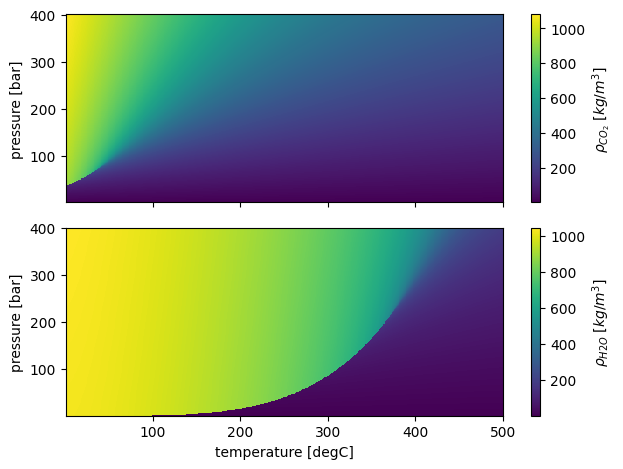

In [24]:
# Plot tables
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True)
#Plot density colormap
rho_pcm_co2 = ax1.pcolormesh(pvt_T, pvt_P, pvt_RHO_CO2)
rho_pcm_h2o = ax2.pcolormesh(pvt_T, pvt_P, pvt_RHO_H2O)

ax2.set_xlabel('temperature [degC]')
ax1.set_ylabel('pressure [bar]')
ax2.set_ylabel('pressure [bar]')

fig.colorbar(rho_pcm_co2, label=r'$\rho_{CO_2}$ [$kg/m^3$]')

fig.colorbar(rho_pcm_h2o, label=r'$\rho_{H2O}$ [$kg/m^3$]')


fig.tight_layout()

## How to use the lookup tables for computing buoyancy pressure

In this example we compute the buoyancy pressure 200 meters above the CO2-water contact at 1500 mTVDMSL

1. We compute the hydrostatic gradient

In [67]:

CO2_contact = 1620.4 #CO2 water contact
sf_depth_msl = 100 #Water depth [meters]
geo_tgrad = 40 #geothermal gradient [degc/km]
sf_temp_degc = 4 # temperature at sea floor [degC] 

In [78]:
# Compute the temperature given the input gradient
def compute_T(z, sf_depth, sf_temp, tgrad) -> float:
    T = sf_temp + max(0, z - sf_depth) * (tgrad / 1000)
    return T

# Ordinary Differential Equation (ODE) system for the pressure and density
def odesys(z: float, y: np.ndarray, sf_depth, sf_temp, tgrad, rho_getter: Callable)  -> Tuple[float]:
    P = y[0]
    T = compute_T(z, sf_depth, sf_temp, tgrad)
    rho = rho_getter(P, T)[0, 0]
    dPdz = rho * const.g / const.bar
    return dPdz,


def _Pdz_odesys(z: float, y: np.ndarray, sf_depth, sf_temp, tgrad, temp_getter: callable, rho_getter: callable)  -> Tuple[float]:
    """
    Calculate the pressure gradient over a depth interval in a well.

    This function computes the derivative of pressure with respect to depth (dPdz) in a fluid column 
    given the depth and current state of pressure. It can be used within numerical methods to solve 
    ordinary differential equations representing the pressure profile along the well.

    Parameters:
    - z (float): The current depth in the well at which we are calculating the pressure gradient.
    - y (np.ndarray): A numpy array containing current state variables, in this context only pressure P.
    - well_header (dict): A dictionary containing metadata or parameters of the well, used by the
                          temperature getter function to compute the current temperature.
    - temp_getter (callable): A function which returns the temperature T at a given depth z 
                              and using well parameters from well_header.
    - rho_getter (callable): A function which returns the density rho of the fluid as a 2D numpy array 
                             at the provided pressure P and temperature T.
    
    Returns:
    - Tuple[float]: A tuple containing a single element, the pressure gradient dPdz (in bar/meter) at depth z.

    """

    P = y[0]
    T = temp_getter(z, sf_depth, sf_temp, tgrad)
    rho = rho_getter(P, T)[0, 0]
    dPdz = rho * const.g / const.bar
    return dPdz,


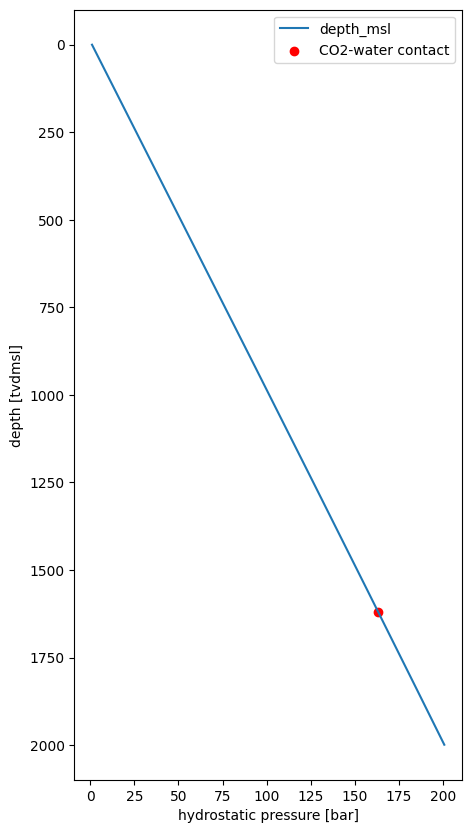

In [88]:
#Make the depth-vector from msl and downwards
dz = 1  #1 meter sampling
td_msl = 2000  #bottom depth
z_vec  = np.arange(0, td_msl, dz)  #generate depth array


#Create dataframe for storing pressures and temperatures. hs_p_df -> HydroStatic_Pressure_DataFrame
hs_p_df = pd.DataFrame(data=z_vec, columns = ['depth_msl'])

#Compute temperature. Constant in water column and as a function of input geothermal gradient
hs_p_df['temp'] = hs_p_df['depth_msl'].map(lambda z: compute_T(z, sf_depth_msl, sf_temp_degc, geo_tgrad))

##Integrate hydrostatic pressure

#Initial conditions: Pressure (atm), depth and temperature at msl
z_0 = 0
P_0 = const.atm / const.bar

#Make interpolators for the imported tables
get_rho_h2o = RectBivariateSpline(pvt_P, pvt_T, pvt_RHO_H2O)
get_rho_co2 = RectBivariateSpline(pvt_P, pvt_T, pvt_RHO_CO2)

# Solve ODEs from z = 0 to the final depth (well depth)
solution = solve_ivp(odesys, [z_0, td_msl], [P_0], args=(sf_depth_msl, sf_temp_degc, geo_tgrad,get_rho_h2o), t_eval=hs_p_df['depth_msl'].values)

#Store hydrostatic pressure in dataframe
hs_p_df['hs_P'] = solution.y[0]

#Interpolate pressure at CO2 contact
p_co2_0 = np.interp(CO2_contact, hs_p_df['depth_msl'], hs_p_df['hs_P'])


#Plot data
fig, ax = plt.subplots(figsize=(5, 10))

#plot hydrostatic pressure
hs_p_df.plot('hs_P', 'depth_msl', ax=ax)

#plot CO2 contact
ax.scatter(p_co2_0, CO2_contact, c= 'r', label = 'CO2-water contact')

ax.set_xlabel('hydrostatic pressure [bar]')
ax.set_ylabel('depth [tvdmsl]')
ax.invert_yaxis()

ax.legend()


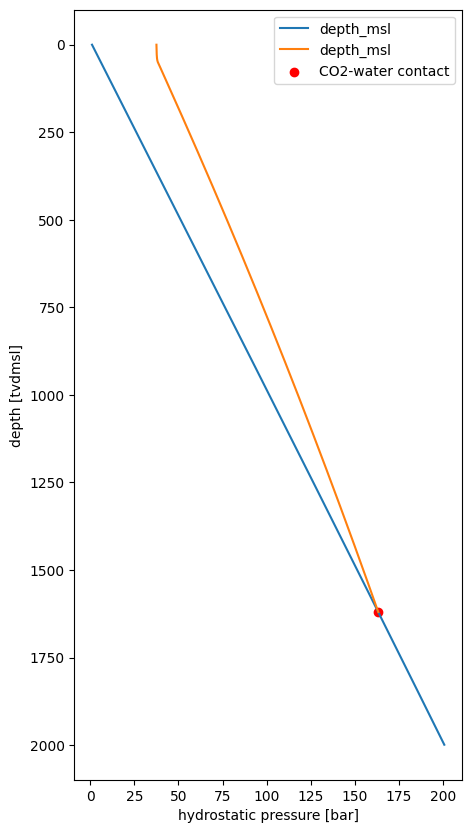

In [89]:
direction = 'up'

pt_df = hs_p_df.copy()


query = pt_df.query('depth_msl<=@CO2_contact')
query = query[::-1]
sign  = -1


z_final = query['depth_msl'].iloc[-1]

#Starting pressure and depth
p0  = p_co2_0
z0 = CO2_contact


#Integrate pressure
solution = solve_ivp(_Pdz_odesys, [z0, z_final], [p0], args=(sf_depth_msl, sf_temp_degc, geo_tgrad, compute_T, get_rho_co2), 
                        t_eval=query['depth_msl'].values, dense_output=True,
                        method = 'Radau')


hs_p_df.loc[query.index, 'co2_P'] = solution.y[0]

#Plot data
fig, ax = plt.subplots(figsize=(5, 10))

#plot hydrostatic pressure
hs_p_df.plot('hs_P', 'depth_msl', ax=ax)

#plot hydrostatic pressure
hs_p_df.plot('co2_P', 'depth_msl', ax=ax)

#plot CO2 contact
ax.scatter(p_co2_0, CO2_contact, c= 'r', label = 'CO2-water contact')

ax.set_xlabel('hydrostatic pressure [bar]')
ax.set_ylabel('depth [tvdmsl]')
ax.invert_yaxis()

ax.legend()